# 3D Rayleigh-Bénard: Equivariant Convolutional Autoencoder

In [5]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('..')

from utils import data_reader
from utils.data_augmentation import DataAugmentation
from torch.utils.data import DataLoader
from utils import training
from utils.evaluation import compute_test_loss
from utils.visualization import auto_encoder_animation
from IPython.display import Video

import escnn
from escnn import gspaces

2025-01-11 02:01:30.680127: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 02:01:30.710869: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-11 02:01:31.258951: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import torch, numpy as np, random
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.set_device(0)
    DEVICE = torch.cuda.current_device()
    print('Current device:', torch.cuda.get_device_name(DEVICE))
else:
    print('Failed to find GPU. Will use CPU.')
    DEVICE = 'cpu'

Current device: NVIDIA A100 80GB PCIe


## Data

In [3]:
BATCH_SIZE = 64

SIMULATION_NAME = 'x48_y48_z32_Ra2500_Pr0.7_t0.01_snap0.125_dur300'

HORIZONTAL_SIZE = int(SIMULATION_NAME.split('_')[0][1:])
HEIGHT = int(SIMULATION_NAME.split('_')[2][1:])

In [4]:
sim_file = os.path.join('..', 'data', 'datasets', f'{SIMULATION_NAME}.h5')

N_train_avail, N_valid_avail, N_test_avail = data_reader.num_samples(sim_file, ['train', 'valid', 'test'])

# Reduce the amount of data manually
N_TRAIN = N_train_avail
N_VALID = N_valid_avail
N_TEST = N_test_avail

train_dataset = data_reader.DataReader(sim_file, 'train', device=DEVICE, shuffle=True, samples=N_TRAIN)
valid_dataset = data_reader.DataReader(sim_file, 'valid', device=DEVICE, shuffle=True, samples=N_VALID)
test_dataset = data_reader.DataReader(sim_file, 'test', device=DEVICE, shuffle=True, samples=N_TEST)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=0, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0, drop_last=False)

print(f'Using {N_TRAIN}/{N_train_avail} training samples')
print(f'Using {N_VALID}/{N_valid_avail} validation samples')
print(f'Using {N_TEST}/{N_test_avail} testing samples')

Using 24060/24060 training samples
Using 8020/8020 validation samples
Using 8020/8020 testing samples


## Hyperparameters

In [5]:
H_KERNEL_SIZE, V_KERNEL_SIZE = 3, 5
NONLINEARITY, STEERABLE_NONLINEARITY = torch.nn.ELU, escnn.nn.ELU

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0
DROP_RATE = 0.2
EARLY_STOPPING = 20 # early stopping patience
EPOCHS = 100

OPTIMIZER = torch.optim.Adam

# not used currently:
USE_LR_SCHEDULER = False
LR_DECAY = 0.1
LR_DECAY_EPOCHS = [10] # epochs at which the learning rate is multiplied by LR_DECAY

## Model Definition

In [6]:
from models.steerable_cnn_model import RBSteerableAutoencoder
from models.steerable_cnn3d_model import RB3DSteerableAutoencoder
from models.cnn_model import RBAutoencoder
from models.cnn3d_model import RB3DAutoencoder

from utils.flipRot2dOnR3 import flipRot2dOnR3


FLIPS, ROTS = True, 4
gspace = gspaces.flipRot2dOnR2 if FLIPS else gspaces.rot2dOnR2
G_size = 2*ROTS if FLIPS else ROTS
model = RBSteerableAutoencoder(gspace=gspace(N=ROTS),
                               rb_dims=(HORIZONTAL_SIZE, HORIZONTAL_SIZE, HEIGHT),
                               encoder_channels=(8, 16, 32, 64),
                               latent_channels=32//G_size,
                               v_kernel_size=V_KERNEL_SIZE, h_kernel_size=H_KERNEL_SIZE,
                               drop_rate=DROP_RATE, nonlinearity=STEERABLE_NONLINEARITY) 

# gspace = flipRot2dOnR3 if FLIPS else gspaces.rot2dOnR3
# G_size = 2*ROTS if FLIPS else ROTS
# model = RB3DSteerableAutoencoder(gspace=gspace(n=ROTS),
#                                  rb_dims=(HORIZONTAL_SIZE, HORIZONTAL_SIZE, HEIGHT),
#                                  encoder_channels=(24, 48, 96, 192),
#                                  latent_channels=32//G_size,
#                                  kernel_size=V_KERNEL_SIZE,
#                                  drop_rate=DROP_RATE, nonlinearity=STEERABLE_NONLINEARITY) 

# model = RBAutoencoder(rb_dims=(HORIZONTAL_SIZE, HORIZONTAL_SIZE, HEIGHT),
#                       encoder_channels=(16, 32, 66, 160),
#                       latent_channels=32,
#                       v_kernel_size=V_KERNEL_SIZE, h_kernel_size=H_KERNEL_SIZE,
#                       drop_rate=DROP_RATE, nonlinearity=NONLINEARITY)

# model = RB3DAutoencoder(rb_dims=(HORIZONTAL_SIZE, HORIZONTAL_SIZE, HEIGHT),
#                         encoder_channels=(40, 80, 168, 320),
#                         latent_channels=32,
#                         v_kernel_size=V_KERNEL_SIZE, h_kernel_size=H_KERNEL_SIZE,
#                         drop_rate=DROP_RATE, nonlinearity=NONLINEARITY)

model.to(DEVICE)
model.summary()

+--------------+--------------------------------+------------+
| Layer        | Output shape [c, |G|, w, d, h] | Parameters |
+--------------+--------------------------------+------------+
| Input        |             [4, 1, 48, 48, 32] |          0 |
| EncoderConv1 |             [8, 8, 48, 48, 32] |     31,232 |
| Pooling1     |             [8, 8, 24, 24, 16] |          0 |
| EncoderConv2 |            [16, 8, 24, 24, 16] |    492,032 |
| Pooling2     |             [16, 8, 12, 12, 8] |          0 |
| EncoderConv3 |             [32, 8, 12, 12, 8] |    983,552 |
| Pooling3     |               [32, 8, 6, 6, 4] |          0 |
| EncoderConv4 |               [64, 8, 6, 6, 4] |  1,966,592 |
| Pooling4     |               [64, 8, 3, 3, 2] |          0 |
| LatentConv   |                [4, 8, 3, 3, 2] |    122,896 |
| DecoderConv1 |               [64, 8, 3, 3, 2] |    123,136 |
| Upsampling1  |               [64, 8, 6, 6, 4] |          0 |
| DecoderConv2 |               [32, 8, 6, 6, 4] |  1,96

## Training

In [7]:
models_dir = './trained_models'

model_name = {RBSteerableAutoencoder: f'{"D" if FLIPS else "C"}{ROTS}cnn',
              RB3DSteerableAutoencoder: f'3D-{"D" if FLIPS else "C"}{ROTS}cnn',
              RBAutoencoder: 'cnn',
              RB3DAutoencoder: '3Dcnn'}[model.__class__]

loss_fn = torch.nn.MSELoss()
optimizer = OPTIMIZER(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# data augmentation only by 90° rotations for efficiency reasons
data_augmentation = DataAugmentation(in_height=model.in_dims[-1], gspace=gspaces.flipRot2dOnR2(N=4))

In [8]:
START_EPOCH = -1 # loads pretrained model if greater 0, loads last available epoch for -1
TRAIN_NAME = 'test1'

initial_early_stop_count, loaded_epoch = training.load_trained_model(model=model, optimizer=optimizer, 
                                                                     train_name=TRAIN_NAME, models_dir=models_dir, 
                                                                     model_name=model_name, epoch=START_EPOCH)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=LR_DECAY_EPOCHS, 
                                                    gamma=LR_DECAY, last_epoch=loaded_epoch-1)

Loaded state at epoch 51 with an early stop count of 0.


/upb/users/f/frommef/profiles/unix/cs/rb-equivariant-cnns/experiments/utils/training.py:214: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)

In [10]:
# training.train(model=model, models_dir=models_dir, model_name=model_name, train_name=TRAIN_NAME, start_epoch=loaded_epoch, 
#                epochs=EPOCHS, train_loader=train_loader, valid_loader=valid_loader, loss_fn=loss_fn, 
#                optimizer=optimizer, lr_scheduler=lr_scheduler, use_lr_scheduler=USE_LR_SCHEDULER, early_stopping=EARLY_STOPPING, only_save_best=True, train_samples=N_TRAIN, batch_size=BATCH_SIZE, 
#                data_augmentation=data_augmentation, plot=True, initial_early_stop_count=initial_early_stop_count)

## Evaluation

### Equivariance Check of Steerable Model

In [24]:
if isinstance(model, escnn.nn.EquivariantModule): # only supported by steerable cnn
    model.check_equivariance(gpu_device=DEVICE, atol=1e-3) 

### Test Loss

In [128]:
mse = compute_test_loss(model, test_loader, torch.nn.MSELoss(), N_TEST, BATCH_SIZE)
rmse = np.sqrt(mse)
mae = compute_test_loss(model, test_loader, torch.nn.L1Loss(), N_TEST, BATCH_SIZE)

print(f'{mse=:.4f}')
print(f'{rmse=:.4f}')
print(f'{mae=:.4f}')

MSELoss():   0%|          | 0/126 [00:00<?, ?batch/s]

L1Loss():   0%|          | 0/126 [00:00<?, ?batch/s]

mse=0.0112
rmse=0.1057
mae=0.0769


### Output Animation

In [ ]:
anim_dir = os.path.join('animations', model_name, TRAIN_NAME)

print('animating...')
for feature in ['t', 'u', 'v', 'w']:
    for axis, dim in enumerate(['width', 'depth', 'height']):
        auto_encoder_animation(slice=24, fps=25, frames=1000, feature=feature, 
                               axis=axis, anim_dir=os.path.join(anim_dir, feature), anim_name=f'{dim}.mp4', 
                               model=model, sim_file=sim_file, device=DEVICE)
        print(f'animated {feature} in the {dim} dimension')

In [14]:
FEATURE = 't' # t, u, v, w
DIM = 'height' # width, depth, height

Video(os.path.join(os.path.join(anim_dir, FEATURE), f'{DIM}.mp4'))

### Latent Space Visualization (Input Sensitivity)

In [6]:
sensitivity_dir = os.path.join('.', 'results', 'latent_sensitivity', model_name)

NameError: name 'model_name' is not defined

In [143]:
from utils.evaluation import compute_latent_sensitivity

SAMPLES = N_TEST

avg_sensitivity, avg_abs_sensitivity = compute_latent_sensitivity(model, test_dataset, samples=SAMPLES, 
                                                                  save_dir=sensitivity_dir,
                                                                  filename=TRAIN_NAME)

  0%|          | 0/8020 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [3]:
from utils.evaluation import load_latent_sensitivity

avg_sensitivity, avg_abs_sensitivity = load_latent_sensitivity(sensitivity_dir, TRAIN_NAME)

NameError: name 'sensitivity_dir' is not defined

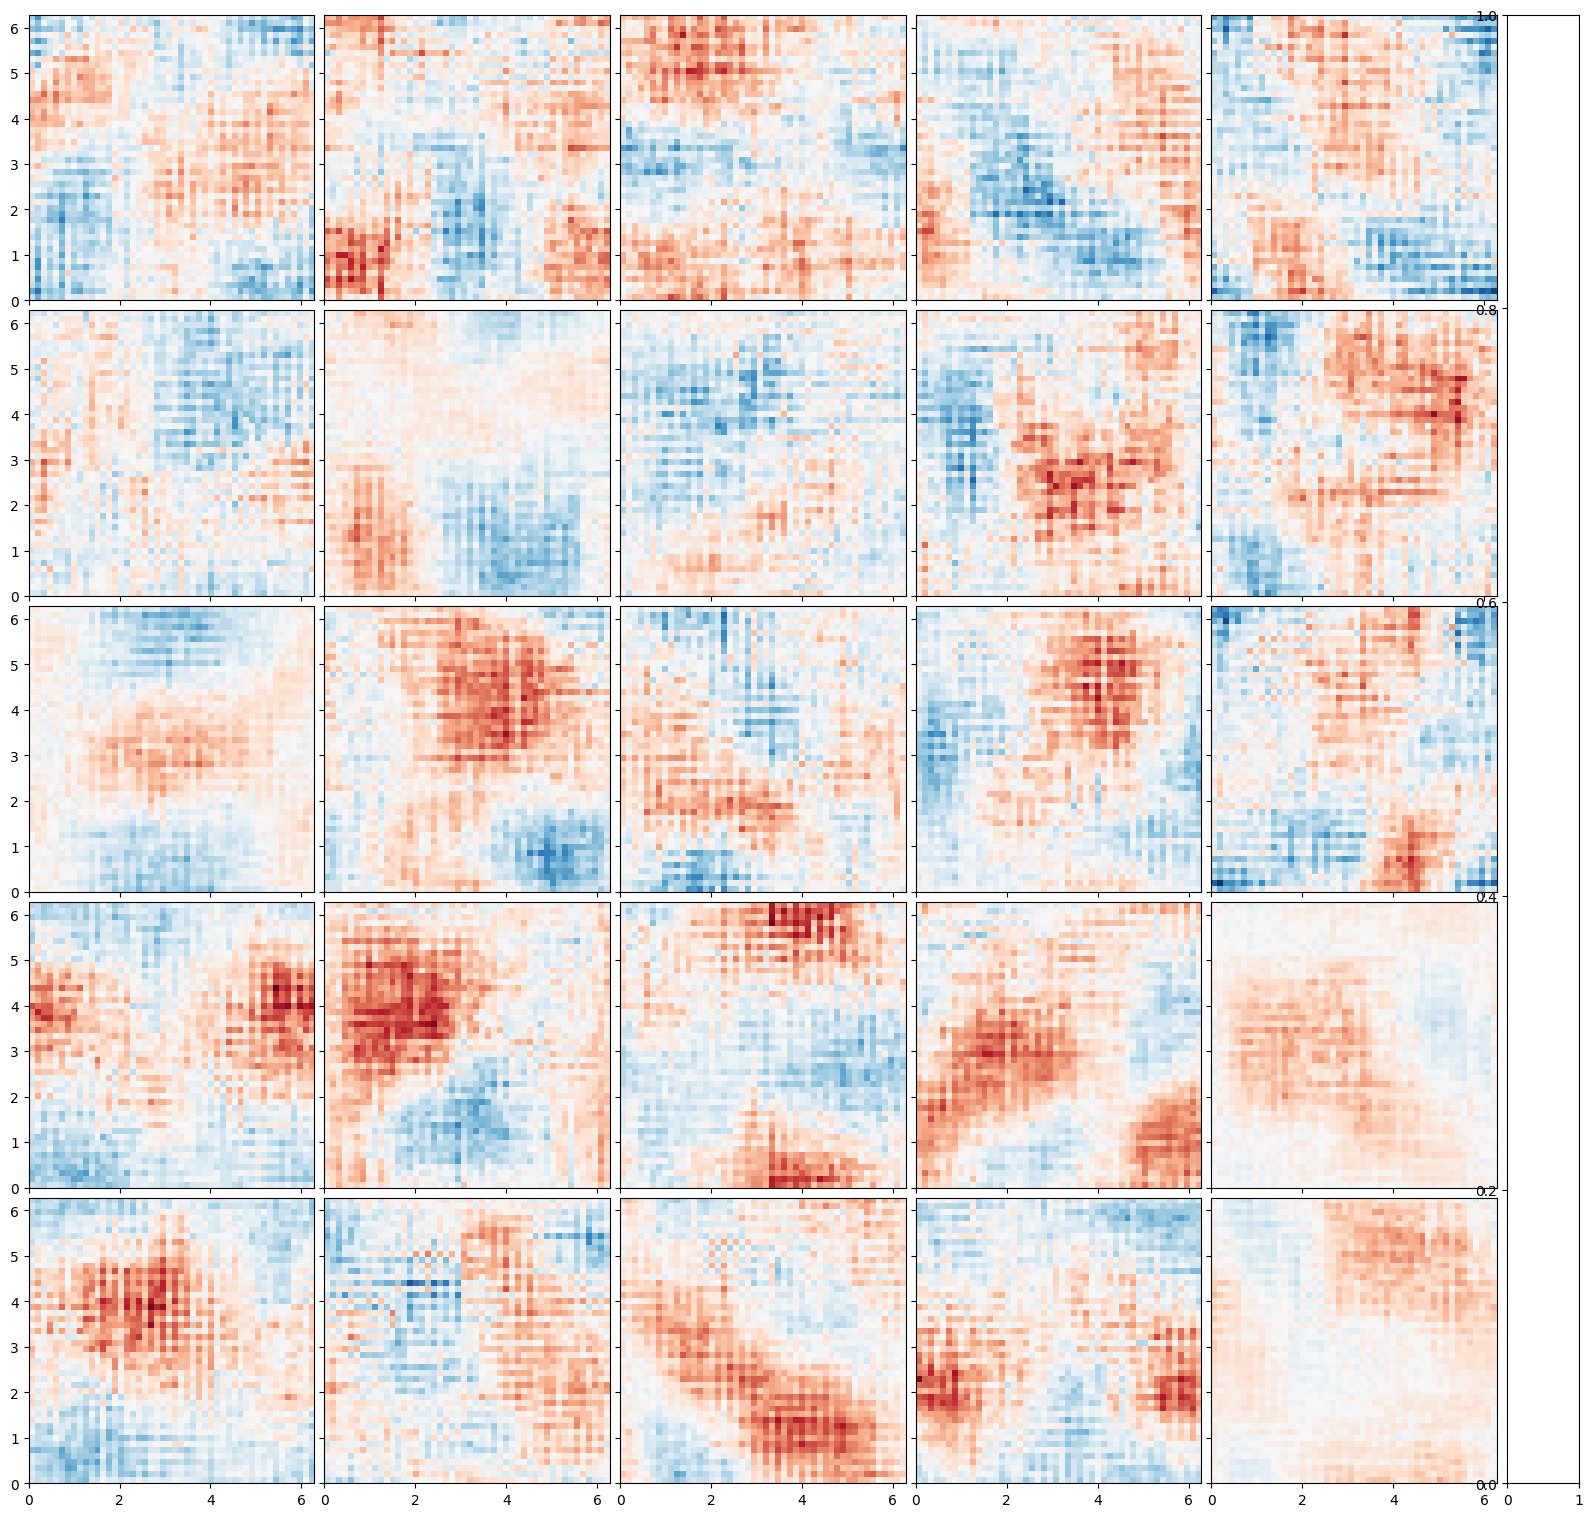

In [151]:
from utils.visualization import show_latent_patterns


ABS_SENSITIVITY = False
CHANNEL = 0
SLICE = 16
AXIS = 2


sensitivity_data = avg_abs_sensitivity if ABS_SENSITIVITY else avg_sensitivity
show_latent_patterns(avg_sensitivity, ABS_SENSITIVITY, num=25, channel=CHANNEL, slice=SLICE, axis=AXIS)